In [1]:
import numpy as np

In [2]:
from dataclasses import dataclass
from typing import Tuple, Mapping, Dict, Sequence, Iterable, Set, List

In [16]:
import matplotlib.pyplot as plt

In [17]:
s = "SPACE"
b = "BLOCK"
g = "GOAL"
maze_grid = {(0, 0): 'SPACE', (0, 1): 'BLOCK', (0, 2): 'SPACE', (0, 3): 'SPACE', (0, 4): 'SPACE', 
             (0, 5): 'SPACE', (0, 6): 'SPACE', (0, 7): 'SPACE', (1, 0): 'SPACE', (1, 1): 'BLOCK',
             (1, 2): 'BLOCK', (1, 3): 'SPACE', (1, 4): 'BLOCK', (1, 5): 'BLOCK', (1, 6): 'BLOCK', 
             (1, 7): 'BLOCK', (2, 0): 'SPACE', (2, 1): 'BLOCK', (2, 2): 'SPACE', (2, 3): 'SPACE', 
             (2, 4): 'SPACE', (2, 5): 'SPACE', (2, 6): 'BLOCK', (2, 7): 'SPACE', (3, 0): 'SPACE', 
             (3, 1): 'SPACE', (3, 2): 'SPACE', (3, 3): 'BLOCK', (3, 4): 'BLOCK', (3, 5): 'SPACE', 
             (3, 6): 'BLOCK', (3, 7): 'SPACE', (4, 0): 'SPACE', (4, 1): 'BLOCK', (4, 2): 'SPACE', 
             (4, 3): 'BLOCK', (4, 4): 'SPACE', (4, 5): 'SPACE', (4, 6): 'SPACE', (4, 7): 'SPACE', 
             (5, 0): 'BLOCK', (5, 1): 'BLOCK', (5, 2): 'SPACE', (5, 3): 'BLOCK', (5, 4): 'SPACE', 
             (5, 5): 'BLOCK', (5, 6): 'SPACE', (5, 7): 'BLOCK', (6, 0): 'SPACE', (6, 1): 'BLOCK', 
             (6, 2): 'BLOCK', (6, 3): 'BLOCK', (6, 4): 'SPACE', (6, 5): 'BLOCK', (6, 6): 'SPACE', 
             (6, 7): 'SPACE', (7, 0): 'SPACE', (7, 1): 'SPACE', (7, 2): 'SPACE', (7, 3): 'SPACE', 
             (7, 4): 'SPACE', (7, 5): 'BLOCK', (7, 6): 'BLOCK', (7, 7): 'GOAL'}

In [18]:
def track(f):
    def wrapped(mdp, vf, s):
        res = f(mdp, vf, s)
        updated = vf.copy()
        mdp.iterates.append(updated)
    return wrapped


@dataclass(frozen=True)
class GridState:
    '''Your code here'''
    x: int
    y: int
    
    def neighbors(self):
        return [GridState(self.x - 1, self.y), GridState(self.x + 1, self.y),
                GridState(self.x, self.y - 1), GridState(self.x, self.y + 1)]

    def __lt__(self, other):
        return (self.x, self.y) < (other.x, other.y)
    
    

class GridMazeMDP:
    
    def __init__(self, maze_dict):
        self.iterates = [] # do not change
        self.tolerance = 1e-8
        '''Your code here, initialize the data you need to solve the MDP
        '''
        self.states: Set[GridState] = set([GridState(x[0], x[1]) for x, y in maze_dict.items()
                                           if y == 'SPACE' or y == 'GOAL'])
        self.goal: GridState = [GridState(x[0], x[1]) for x, y in maze_dict.items() if y == 'GOAL'][0]
        self.gamma: float = 1
    
    def plot_convergence(self):
        '''do not change'''
        sorted_vfs = np.array([[y[1] for y in sorted(x.items())] for x in self.iterates])
        true_vf = sorted_vfs[-1, :]
        convergences = np.linalg.norm(sorted_vfs - true_vf, axis=1)
        plt.plot(convergences)
    
    @track
    def update_value_function_for_state(self, value_function: Mapping[GridState, float], s: GridState):
        '''
        Your code here: perform an in place update to value function for state 
        Runetime: O(1)
        '''
        if s != self.goal:
            neighbor_value_functions = []
            for neighbor in s.neighbors():
                if neighbor == self.goal:
                    neighbor_value_functions.append(1 + self.gamma*value_function[neighbor])
                elif neighbor in self.states:
                    neighbor_value_functions.append(self.gamma*value_function[neighbor])
            value_function[s] = max(neighbor_value_functions)
        else:
            value_function[s] = 0
            
    
    def in_place_value_iteration(self) -> Mapping[GridState, float]:
        '''Your code here (Maybe, maybe leave as an example)
        run in place value iteration until the max change of the VF over all states
        is less than self.tolerance
        hint: this implementation should call update_value_function_for_state in it's inner loop
        '''
        value_function = {s: 0 for s in self.states}
        max_change = 1
        while max_change > self.tolerance:
            max_change = 0
            for state in self.states:
                old_val = value_function[state]
                self.update_value_function_for_state(value_function, state)
                max_change = max(max_change, abs(old_val - value_function[state]) > self.tolerance)
        return value_function
    
    
    def influence_tree_VI(self) -> Mapping[GridState, float]:
        '''Your code here
        run value tree iteration as descibed in the algorithm until the max change of 
        the VF over all states is less than self.tolerance
        hint: make sure you are not adding states to the update set more than you need to
        '''
        value_function = {s: 0 for s in self.states}
        influence_tree = self.get_influence_tree()
        to_update = [s for s in self.states]
        in_list = {s: True for s in self.states}
        while len(to_update) > 0:
            next_state = to_update.pop(0)
            in_list[next_state] = False
            old_val = value_function[next_state]
            self.update_value_function_for_state(value_function, next_state)
            if abs(old_val - value_function[next_state]) > self.tolerance:
                for s in influence_tree[next_state]:
                    if not in_list[s]:
                         to_update.append(s)
        return value_function
            
            
    def get_influence_tree(self):
        '''just a method I wrote, does not need to be implemented to solve the problem'''
        influence_tree = {}
        count = 0
        for state in self.states:
            influence_tree[state] = []
            for neighbor in state.neighbors():
                if neighbor != self.goal and neighbor in self.states:
                    influence_tree[state].append(neighbor)
        return influence_tree

    

In [19]:
gm1 = GridMazeMDP(maze_grid)
gm2 = GridMazeMDP(maze_grid)

In [20]:
vf1 = gm1.in_place_value_iteration()

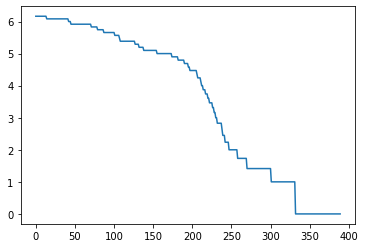

In [21]:
gm1.plot_convergence()

In [22]:
vf2 = gm2.influence_tree_VI()

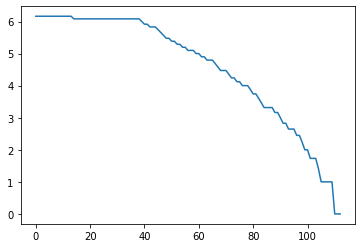

In [23]:
gm2.plot_convergence()

In [283]:
from typing import Tuple, Mapping, Dict, Sequence, Iterable, Set
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.dynamic_programming import value_iteration_result
from rl.distribution import Categorical
from scipy.stats import poisson

IntPair = Tuple[int, int]
CareerDecisionsMap = Mapping[int, Mapping[
    IntPair,
    Categorical[Tuple[int, float]]
]]


class CareerOptimization(FiniteMarkovDecisionProcess[int, IntPair]):

    def __init__(
        self,
        hours: int,
        wage_cap: int,
        alpha: float,
        beta: float
    ):
        self.hours = hours
        self.wage_cap = wage_cap
        self.alpha = alpha
        self.beta = beta
        super().__init__(self.get_transitions())

    def get_transitions(self) -> CareerDecisionsMap:
        d: Dict[int, Mapping[IntPair, Categorical[Tuple[int, float]]]] = {}
        for w in range(1, self.wage_cap + 1):
            d1: Dict[IntPair, Categorical[Tuple[int, float]]] = {}
            for s in range(self.hours + 1):
                for t in range(self.hours + 1 - s):
                    pd = poisson(self.alpha * t)
                    prob: float = self.beta * s / self.hours
                    r: float = w * (self.hours - s - t)
                    same_prob: float = (1 - prob) * pd.pmf(0)
                    sr_probs: Dict[Tuple[int, float], float] = {}
                    if w == self.wage_cap:
                        sr_probs[(w, r)] = 1.
                    elif w == self.wage_cap - 1:
                        sr_probs[(w, r)] = same_prob
                        sr_probs[(w + 1, r)] = 1 - same_prob
                    else:
                        sr_probs[(w, r)] = same_prob
                        sr_probs[(w + 1, r)] = prob * pd.pmf(0) + pd.pmf(1)
                        for w1 in range(w + 2, self.wage_cap):
                            sr_probs[(w1, r)] = pd.pmf(w1 - w)
                        sr_probs[(self.wage_cap, r)] = \
                            1 - pd.cdf(self.wage_cap - w - 1)
                    d1[(s, t)] = Categorical(sr_probs)
            d[w] = d1
        return d




{1: (0, 10),
 2: (0, 10),
 3: (0, 10),
 4: (0, 10),
 5: (0, 10),
 6: (0, 10),
 7: (0, 10),
 8: (0, 10),
 9: (0, 10),
 10: (0, 10),
 11: (0, 10),
 12: (0, 10),
 13: (0, 10),
 14: (10, 0),
 15: (10, 0),
 16: (0, 0),
 17: (0, 0),
 18: (0, 0),
 19: (0, 0),
 20: (0, 0),
 21: (0, 0),
 22: (0, 0),
 23: (0, 0),
 24: (0, 0),
 25: (0, 0),
 26: (0, 0),
 27: (0, 0),
 28: (0, 0),
 29: (0, 0),
 30: (0, 0)}


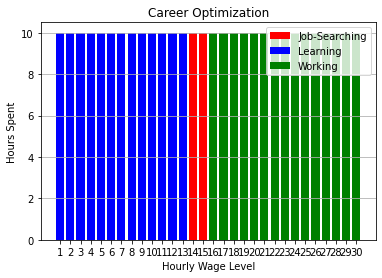

In [6]:
import matplotlib.pyplot as plt
from pprint import pprint
hours: int = 10
wage_cap: int = 30
alpha: float = 0.08
beta: float = 0.82
gamma: float = 0.95

co: CareerOptimization = CareerOptimization(
    hours=hours,
    wage_cap=wage_cap,
    alpha=alpha,
    beta=beta
)

_, opt_policy = value_iteration_result(co, gamma=gamma)
wages: Iterable[int] = range(1, co.wage_cap + 1)
opt_actions: Mapping[int, Tuple[int, int]] = \
    {w: opt_policy.act(w).value for w in wages}
searching: Sequence[int] = [s for _, (s, _) in opt_actions.items()]
learning: Sequence[int] = [l for _, (_, l) in opt_actions.items()]
working: Sequence[int] = [co.hours - s - l for _, (s, l) in
                          opt_actions.items()]
pprint(opt_actions)
plt.xticks(wages)
p1 = plt.bar(wages, searching, color='red')
p2 = plt.bar(wages, learning, color='blue')
p3 = plt.bar(wages, working, color='green')
plt.legend((p1[0], p2[0], p3[0]), ('Job-Searching', 'Learning', 'Working'))
plt.grid(axis='y')
plt.xlabel("Hourly Wage Level")
plt.ylabel("Hours Spent")
plt.title("Career Optimization")
plt.show()

{1: 1259.6505463571575, 2: 1340.4150825113318, 3: 1426.3579675768017, 4: 1517.8112197724167, 5: 1615.1281452018854, 6: 1718.6847027661358, 7: 1828.8809566174634, 8: 1946.1426214511087, 9: 2070.9227044508684, 10: 2203.703265781422, 11: 2344.9974845940746, 12: 2495.3513750395914, 13: 2655.3257070212426, 14: 2825.6334602893544, 15: 3006.9963300832114, 16: 3199.9999489010643, 17: 3399.999945707381, 18: 3599.9999425136975, 19: 3799.9999393200146, 20: 3999.9999361263312, 21: 4199.999932932646, 22: 4399.999929738963, 23: 4599.999926545279, 24: 4799.999923351597, 25: 4999.999920157914, 26: 5199.99991696423, 27: 5399.999913770545, 28: 5599.999910576863, 29: 5799.9999073831805, 30: 5999.999904189495, 31: 6199.999900995813, 32: 6399.9998978021285, 33: 6599.999894608446, 34: 6799.999891414762, 35: 6999.999888221078, 36: 7199.999885027395, 37: 7399.999881833711, 38: 7599.999878640029, 39: 7799.999875446344, 40: 7999.9998722526625, 41: 8199.999869058975, 42: 8399.999865865291, 43: 8599.999862671611,

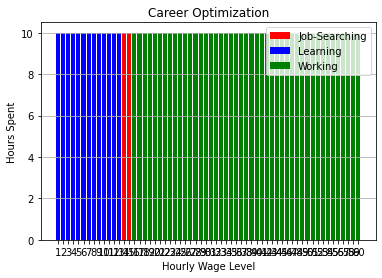

In [17]:
import matplotlib.pyplot as plt
from pprint import pprint
hours: int = 10
wage_cap: int = 60
alpha: float = 0.08
beta: float = 0.82
gamma: float = 0.95

co: CareerOptimization = CareerOptimization(
    hours=hours,
    wage_cap=wage_cap,
    alpha=alpha,
    beta=beta
)

opt_vf, opt_policy = value_iteration_result(co, gamma=gamma)
print(opt_vf)
wages: Iterable[int] = range(1, co.wage_cap + 1)
opt_actions: Mapping[int, Tuple[int, int]] = \
    {w: opt_policy.act(w).value for w in wages}
searching: Sequence[int] = [s for _, (s, _) in opt_actions.items()]
learning: Sequence[int] = [l for _, (_, l) in opt_actions.items()]
working: Sequence[int] = [co.hours - s - l for _, (s, l) in
                          opt_actions.items()]
pprint(opt_actions)
plt.xticks(wages)
p1 = plt.bar(wages, searching, color='red')
p2 = plt.bar(wages, learning, color='blue')
p3 = plt.bar(wages, working, color='green')
plt.legend((p1[0], p2[0], p3[0]), ('Job-Searching', 'Learning', 'Working'))
plt.grid(axis='y')
plt.xlabel("Hourly Wage Level")
plt.ylabel("Hours Spent")
plt.title("Career Optimization")
plt.show()

In [ ]:
s = "SPACE"
b = "BLOCK"
maze_grid = {
    (0, 0): s,
    (0, 1): b,
    (0, 2): s,
    (0, 3): s,
    (0, 4): s,
    (0, 5): s,
    (0, 6): s,
    (0, 7): s,
    
    (1, 0): s,
    (1, 1): b,
    (1, 2): b,
    (1, 3): s,
    (1, 4): b,
    (1, 5): b,
    (1, 6): b,
    (1, 7): b,
    
    (2, 0): s,
    (2, 1): b,
    (2, 2): s,
    (2, 3): s,
    (2, 4): s,
    (2, 5): s,
    (2, 6): b,
    (2, 7): s,
    
    (3, 0): s,
    (3, 1): s,
    (3, 2): s,
    (3, 3): b,
    (3, 4): b,
    (3, 5): s,
    (3, 6): b,
    (3, 7): s,
    
    (4, 0): s,
    (4, 1): b,
    (4, 2): s,
    (4, 3): b,
    (4, 4): s,
    (4, 5): s,
    (4, 6): s,
    (4, 7): s,

    (5, 0): b,
    (5, 1): b,
    (5, 2): s,
    (5, 3): b,
    (5, 4): s,
    (5, 5): b,
    (5, 6): s,
    (5, 7): b,
    
    (6, 0): s,
    (6, 1): b,
    (6, 2): b,
    (6, 3): b,
    (6, 4): s,
    (6, 5): b,
    (6, 6): s,
    (6, 7): s,
    
    (7, 0): s,
    (7, 1): s,
    (7, 2): s,
    (7, 3): s,
    (7, 4): s,
    (7, 5): b,
    (7, 6): b,
    (7, 7): s
}